In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from scipy.optimize import least_squares

In [2]:
def bresenhamLine(x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = -1 if x0 > x1 else 1
    sy = -1 if y0 > y1 else 1
    err = dx - dy

    points = []

    while True:
        points.append((x0, y0))

        if x0 == x1 and y0 == y1:
            break

        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy

    return points

def calculateCoordinates(fnid_value):
    """
    提供fnid,计算格网的横纵坐标
    """
    x = fnid_value % 357
    y = fnid_value // 357
    return x, y

def fnid_from_coordinates(x, y):
    """
    根据格网的横纵坐标,计算fnid
    """
    return y * 357 + x

def odLineFnids(fnid_o, fnid_d):
    """
    计算起始点到终止点直线经过的fnid格网编号
    """
    x0, y0 = calculateCoordinates(fnid_o)
    x1, y1 = calculateCoordinates(fnid_d)

    line_points = bresenhamLine(x0, y0, x1, y1)

    fnids = [fnid_from_coordinates(x, y) for x, y in line_points]
    return fnids

In [3]:
grid=gpd.read_file('../data/shp/nanshan_value/nanshan_value.shp')
od_cluster_df = pd.read_csv('../data/od_cluster.csv')

od_cluster_df = od_cluster_df.drop_duplicates(subset=['origin_lat', 'origin_lng', 'destination_lat', 'destination_lng'])

In [4]:
gdf = gpd.read_file('../data/shp/nanshan_value/nanshan_value.shp')
gdf['id'] = range(1, len(gdf) + 1)
max_id = max(gdf['id'])
min_value = gdf['states'].min()
max_value = gdf['states'].max()
gdf['states'] = ((gdf['states'] - min_value) / (max_value - min_value)) * (2 - 0) + 0 # 归一化为0-2

In [5]:
od_cluster_df['source_geometry'] = [Point(xy) for xy in zip(od_cluster_df.origin_lng, od_cluster_df.origin_lat)]
od_cluster_df['target_geometry'] = [Point(xy) for xy in zip(od_cluster_df.destination_lng, od_cluster_df.destination_lat)]

coefficients = {}
for index,row in od_cluster_df.iterrows():
    source_point = row['source_geometry']  
    target_point = row['target_geometry']
    fnid_o = gdf[gdf.contains(source_point)]['fnid'].values[0] if gdf.contains(source_point).any() else None
    fnid_d = gdf[gdf.contains(target_point)]['fnid'].values[0] if gdf.contains(target_point).any() else None
    if not fnid_o or not fnid_d:
        continue

    fnid_list=odLineFnids(fnid_o, fnid_d)
    matched_gdf = gdf[gdf['fnid'].isin(fnid_list)]

    # N = len(matched_gdf)*1
    N = sum(matched_gdf['states'])
    omega = (row['count']) 
    C = np.log(omega)

    id_list = matched_gdf['id'].to_list()

    for id in matched_gdf['id']:
        if id not in coefficients:
            coefficients[id] = {'N': 0, 'C_sum': 0, 'count': 0, 'id_lists': []}
        coefficients[id]['N'] += N
        coefficients[id]['C_sum'] += C
        coefficients[id]['count'] += 1
        coefficients[id]['id_lists'].append(id_list)

e:\Anaconda\envs\django\lib\site-packages\pandas\core\dtypes\cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [16]:
# 准备最小二乘法的输入
ids = list(coefficients.keys())

id_seq = {}
for i in range(len(ids)):
    id_seq[ids[i]] = i

def total_residual(x):
    residual = []
    for i, id in enumerate(ids):
        coeff = coefficients[id]
        N = coeff['N']
        C_sum = coeff['C_sum']
        count = coeff['count']
        
        this_id_residual = []
        for id_list in coeff['id_lists']:
            b = np.zeros(len(ids))  
            for id in id_list:
                seq = id_seq[id]
                b[seq] = 1
            this_id_residual.append(np.dot(b, x) - (N / count - C_sum / count))
        residual.append(np.sum(this_id_residual))
    
    return residual

x0 = np.zeros(len(ids))  # initialization

result = least_squares(total_residual, x0)

# 将结果映射回原始id空间
optimized_values = {id: result.x[i] for i, id in enumerate(ids)}

print("优化后的结果：", optimized_values)
# print("优化后的残差：", result.fun)

优化后的结果： {372: -2.2565538681714767, 673: -0.3557521949325988, 676: -0.8096003416184206, 962: 2.074690925399836, 1282: 2.9196173021609515, 307: 1.1047110673406606, 768: -1.1220724985664443, 300: 1.2368792854922939, 396: 1.1621323776451682, 505: 1.8116060419417535, 615: 0.6050499863534902, 671: -1.3189419182842603, 865: 0.10785688043650528, 1333: 2.0302738085137597, 1335: 2.53225564264974, 366: 0.6811590959054051, 398: -1.0149825742010352, 432: 0.11706534507356448, 434: 1.5659579978240163, 1149: 1.469399481675985, 1214: 2.0420548700600327, 224: 0.48601682017555453, 448: -0.4039225365590439, 540: 2.407057232236664, 597: -0.09840031623911015, 628: 4.2508123842651155, 655: -2.1756650975173812, 686: -0.5784685615467782, 24: -3.3068126123527164, 240: 8.012364079173544, 347: -4.632879733024079, 379: -2.1964503172647847, 567: 1.5717520244177912, 140: -0.6920130813866936, 743: 5.203455210136288, 811: -4.953041293890808, 972: 0.8148681853605251, 1163: 2.6345019227062814, 207: -6.30642561376498, 23

In [7]:
gdf['ds'] = gdf.states

for index, row in gdf.iterrows():
    row_id = row['id']  # 假设gdf中用于标识每行的列名为'id'
    if row_id in optimized_values:
        # 如果当前行的id在optimized_values中，更新其值
        gdf.at[index, 'ds'] = optimized_values[row_id]


In [8]:
# gdf['ds']=np.log2(gdf['ds'] + abs(gdf['ds'].min()) + 1) # LOG

In [9]:
# gdf = gdf.drop('encoding', axis=1)
gdf.to_file('../data/cmap/cmap_distance.shp', driver='ESRI Shapefile', crs='EPSG:4326')

# 最小二乘回归后，对结果的检验

## 残差图

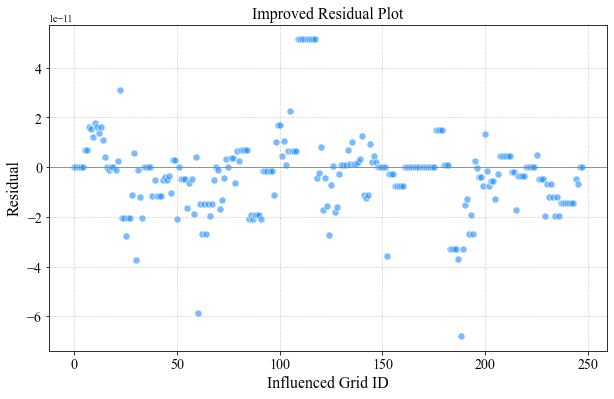

In [10]:
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(10, 6))
plt.scatter(range(len(result.fun)), result.fun, alpha=0.6, edgecolors='w', s=50, color='dodgerblue')
plt.title('Improved Residual Plot', fontsize=16)
plt.xlabel('Influenced Grid ID', fontsize=16)
plt.ylabel('Residual', fontsize=16)
plt.axhline(0, color='grey', linewidth=0.8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

## RSS 残差平方和

In [11]:
import numpy as np
from scipy.optimize import least_squares

def calculate_rss(residuals):
    """计算残差平方和"""
    return np.sum(np.square(residuals))

# 使用least_squares得到的结果计算残差
residuals = total_residual(result.x)

# 计算RSS
RSS = calculate_rss(residuals)
print("残差平方和(RSS):", RSS)

残差平方和(RSS): 6.789402738960431e-20
